# Build the weed map for the field-1 dataset

In [1]:
# Load libraries
from glob import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.metrics import *
from fastai.vision.all import *
import cv2

In [4]:
def label_func(fn):
    path_mask = Path("/data/weed_data/kfold_5ds/labels")
    return path_mask/f"{fn.parent.stem}"/ f"{fn.stem.replace('image', 'mask')}{fn.suffix}"
# Prepare datasets # Load the data
codes = np.loadtxt("/data/weed_data/inputImages_Masks/codes.txt", dtype='str')
path = Path('/data/weed_data/kfold_5ds/images')

In [6]:
# Get the predictions from the validation set
def export_predictions(imlist, outdir):
    for im in imlist:
        filename = os.path.basename(im).replace("mosaic_", "mosaic_prediction")
        filename = filename.replace("jpeg", "npy")
        impred = learn.predict(im)
        # there are three prediction layers
        # but the first two are identical np.unique(preds[0] == preds[1])
        impred = impred[0].detach().numpy()
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        out_path = outdir + "/" + filename
        np.save(out_path, impred)

In [5]:
# Prepare the dataloader
# Because I am using this train-val dataset for essentially nothing, I will load them blended in
weedt = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items = get_image_files,
                  get_y = label_func,
                  splitter=RandomSplitter(valid_pct=0.2),
                  batch_tfms=Normalize)

# create the data loader
dls= weedt.dataloaders(path, folders=("1","2", "3", "4", "5"), path=path, bs=4)
learn = unet_learner(dls,
                     resnet18,
                     n_out=3,
                     self_attention=True,
                     normalize=True,
                     pretrained=True,
                     loss_func=DiceLoss(),
                     opt_func=Adam,
                     lr= 0.001,
                     wd=None,
                     metrics=[DiceMulti, JaccardCoeff]).to_fp16()

/home/modanilevicz/.local/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
# Load the trained model
learn.load('/data/weed_data/model_weights/unet18_1fold')

In [8]:
# Export the predicted masks
mosaic_im = glob.glob("/data/weed_data/mosaic_prediction/jpeg_images/*")
export_predictions(mosaic_im,
                   "/data/weed_data/mosaic_prediction/npy_predicted")

/home/modanilevicz/.local/lib/python3.8/site-packages/fastai/metrics.py:375: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


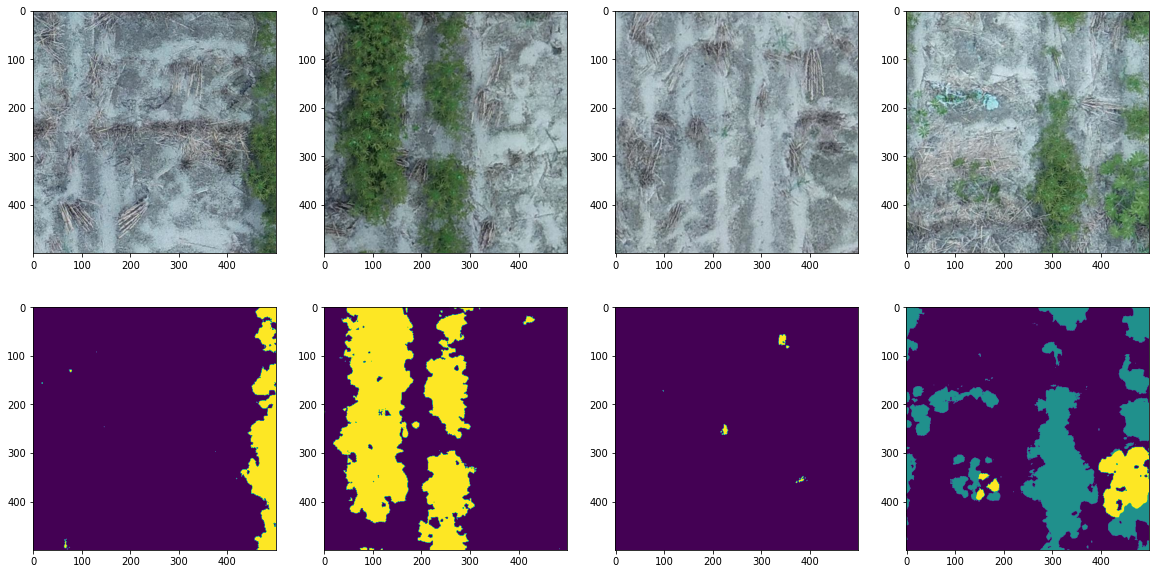

In [20]:
# Sanity checks on the predictions and comparison with RGB version
fig, axs = plt.subplots(2,4, figsize=(20,10))
axs = axs.ravel()

import random
imagelist = random.choices(mosaic_im, k=4)

for i, impath in enumerate(imagelist):
    image = cv2.imread(impath)
    predpath = impath.replace("jpeg_images", "npy_predicted")\
    .replace("_mosaic", "_mosaic_prediction")\
    .replace("jpeg", "npy")
    prediction = np.load(predpath)
    axs[i].imshow(image)
    axs[i+4].imshow(prediction)


They look good (in a sense that it seems to have worked) although the prediction accuracy is far from fantastic.

In [40]:
# Build the orthomosaic version
# 47 ROW & 46 COLUMN

numpy_images = sorted(glob.glob("/data/weed_data/mosaic_prediction/npy_images/*"))
print(f"Total number of images {len(numpy_images)}")

Total number of images 2162


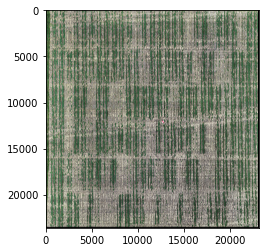

In [7]:
# rebuilding per row
count = 0
Row, Column = 47,46
rebuilt_RGB = np.zeros(shape=(23600,23100,3), dtype='uint8')

for row in range(47):
    for column in range(46):
        image_path = f"/data/weed_data/mosaic_prediction/npy_images/160721_RGB_mosaic_{count}.npy"
        image = np.load(image_path)

        col_start = 500*column
        col_stop = 500*(column+1)
        
        row_start = 500*row
        row_stop = 500*(row+1)

#         print(image_path)
#         print(f" Image number {count} has [{row_start}:{row_stop}, {col_start}:{col_stop}]")
    
        rebuilt_RGB[row_start:row_stop, col_start:col_stop, :] = image
        count+=1

plt.imshow(rebuilt_RGB)

In [13]:
# Save as NPY and JPEG
np.save("/data/weed_data/mosaic_prediction/160721_RGB_reduced.npy", rebuilt_RGB)

from PIL import Image
im = Image.fromarray(rebuilt_RGB)
im.save("/data/weed_data/mosaic_prediction/160721_RGB_reduced.jpeg")

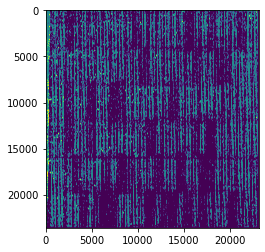

In [11]:
# rebuilding per row -MASK
count = 0
Row, Column = 47,46
rebuilt_MASK = np.zeros(shape=(23600,23100), dtype='uint8')

for row in range(47):
    for column in range(46):
        image_path = f"/data/weed_data/mosaic_prediction/npy_predicted/160721_RGB_mosaic_prediction_{count}.npy"
        image = np.load(image_path)

        col_start = 500*column
        col_stop = 500*(column+1)
        
        row_start = 500*row
        row_stop = 500*(row+1)

#         print(image_path)
#         print(f" Image number {count} has [{row_start}:{row_stop}, {col_start}:{col_stop}]")
    
        rebuilt_MASK[row_start:row_stop, col_start:col_stop] = image
        count+=1

plt.imshow(rebuilt_MASK)

In [14]:
# Save as NPY and JPEG
np.save("/data/weed_data/mosaic_prediction/160721_RGB_PREDICTION.npy", rebuilt_MASK)

from PIL import Image
im = Image.fromarray(rebuilt_MASK)
im.save("/data/weed_data/mosaic_prediction/160721_RGB_PREDICTION.jpeg")

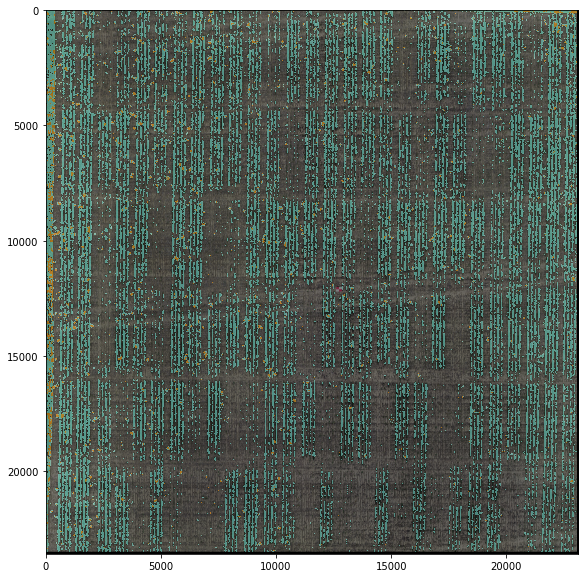

In [38]:
# Overlay both images
fig, axs = plt.subplots(figsize=(10,10))
from matplotlib.colors import ListedColormap
colors = ListedColormap(["#000000","#72ccd1", "#ff7d00"])

axs.imshow(rebuilt_RGB)
axs.imshow(rebuilt_MASK,cmap=colors, alpha=0.5)

plt.savefig("rebuilt_mosaic.png", dpi=300)

# Measure the percentages

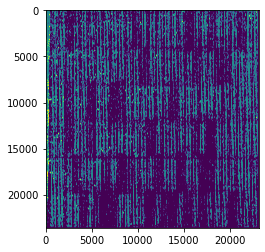

In [2]:
masked_mosaic = np.load("/data/weed_data/mosaic_prediction/160721_RGB_PREDICTION.npy")
plt.imshow(masked_mosaic)

In [6]:
# Total areas to calculate the percentage of sandplain
print(f" Total image size : {np.size(masked_mosaic)}")
print(f" Total plant area: {np.size(masked_mosaic[masked_mosaic ==2]) + np.size(masked_mosaic[masked_mosaic ==1])}")

 Total image size : 545160000
 Total plant area: 152557123


In [40]:
codes = np.loadtxt("/data/weed_data/inputImages_Masks/codes.txt", dtype='str')
codes

array(['soil', 'crop', 'blue_lupins'], dtype='<U11')

In [7]:
# How much of the plant estimated area is NLL or SL
total_plant = np.size(masked_mosaic[masked_mosaic ==2]) + np.size(masked_mosaic[masked_mosaic ==1])
nll = np.size(masked_mosaic[masked_mosaic ==1])
sl = np.size(masked_mosaic[masked_mosaic ==2])

print(f"Narrow-leafed lupin occupies {(nll*100)/total_plant }% of the plant area")
print(f"Sandplain lupin occupies {(sl*100)/total_plant }% of the plant area")                                                               

Narrow-leafed lupin occupies 94.59873794290156% of the plant area
Sandplain lupin occupies 5.4012620570984415% of the plant area


In [8]:
# How much of the field is occupied by sl and should be sprayed?
ttl_area = np.size(masked_mosaic)

print(f"Area that should be sprayed is {(sl*100)/ttl_area} of the field")

Area that should be sprayed is 1.511484701738939 of the field


In [42]:
# what is the percentage of the field sprayed?
print(np.unique(rebuilt_MASK))

# Blues are id 2 - what is the percentage of the field?
np.size(rebuilt_MASK)

[0 1 2]


545160000

In [50]:
np.size(rebuilt_MASK[rebuilt_MASK ==2])

8240010

In [54]:
545160000 / 82400100

6.616011388335694

In [56]:
545160000 * 0.0066

3598056.0

In [19]:
# from blend_modes import darken_only

In [23]:
# rebuilt_RGB_float = rebuilt_RGB.astype(np.float16) / 255
# rebuilt_MASK_float = rebuilt_MASK.astype(np.float16) / 255

In [33]:
# rebuilt_RGB_float_alpha = np.zeros((23600, 23100, 4), "float")
# rebuilt_RGB_float_alpha[:,:,:3] = rebuilt_RGB_float

# rebuilt_MASK_float_alpha = np.zeros((23600, 23100, 4), "float")
# rebuilt_MASK_float_alpha[:,:,0] = rebuilt_MASK_float

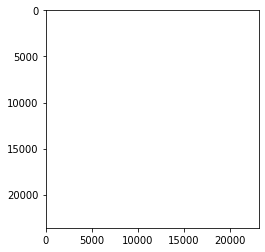

In [34]:
# Using the blend modes library
# blended_img = darken_only(rebuilt_RGB_float_alpha, rebuilt_MASK_float_alpha, opacity=0.7)
# plt.imshow(blended_img)

In a test below, I can see that some chunks of the plots were not used for the prediction or training due to the way the chunks were cut. Because of that, I decided to use the unet model to predict from the whole orthomosaic (cut into 500x500) and all the plots (cut into 500 x 500).

That way, I know where all the mask is suppose to sit and it will be easier to map the validation lupins.

In [3]:
plots = glob("/scratch/pawsey0149/modanilevicz/weed_data/inputImages_Masks/F1_field_160721/*image.npy")

In [4]:
# Load the model 
from fastai.metrics import *
from fastai.vision.all import *

def label_func(fn):
    path_mask = Path("/data/weed_data/kfold_5ds/labels")
    return path_mask/f"{fn.parent.stem}"/ f"{fn.stem.replace('image', 'mask')}{fn.suffix}"

# Prepare datasets # Load the data
codes = np.loadtxt("/data/weed_data/inputImages_Masks/codes.txt", dtype='str')
path = Path('/data/weed_data/kfold_5ds/images')
weedt = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items = get_image_files,
                  get_y = label_func,
                  splitter=RandomSplitter(valid_pct=0.2),
                  batch_tfms=Normalize)

# create the data loader
dls= weedt.dataloaders(path, folders=("1","2", "3", "4", "5"), path=path, bs=4)
# Define the model architecture
learn = unet_learner(dls,
                     resnet18,
                     n_out=3,
                     self_attention=True,
                     normalize=True,
                     pretrained=True,
                     loss_func=DiceLoss(),
                     opt_func=Adam,
                     lr= 0.001,
                     wd=None,
                     metrics=[DiceMulti, JaccardCoeff]).to_fp16()

/home/modanilevicz/.local/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [6]:
# Get the predictions from the validation set
def export_predictions(imlist, outdir):
    for im in imlist:
        filename = os.path.basename(im).replace("image", "prediction")
        impred = learn.predict(im)
        # there are three prediction layers but two are identical np.unique(preds[0] == preds[1])
        impred = impred[0].detach().numpy()
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        out_path = outdir + "/" + filename
        np.save(out_path, impred)

In [ ]:
# Tranform the images into jpgs

In [7]:
# Kfold 1 model
learn.load('/data/weed_data/model_weights/unet18_1fold')
# # Export the predicted masks
export_predictions(plots,
                   "/data/weed_data/mosaic_prediction/")

UnidentifiedImageError: cannot identify image file '/scratch/pawsey0149/modanilevicz/weed_data/inputImages_Masks/F1_field_160721/id_A_2_treat_10_image.npy'

# Test 

In [7]:
# Find all the images
# train + validation sets
tv_sets = glob("/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/unet_VALIDATION_pred_fold1/f1*")
# test set
te_set = glob("/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/1fold_predicted_holdoutset/f1_id_*")
total_set = tv_sets +te_set
len(total_set)

929

Above are the images I have from train, validation and holdout from F1 dataset.
I will need them all to rebuild the mosaic

In [8]:
# What RGB images do I have for the plots?
rgb_tv = glob("/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/images/*/f1_id*")
rgb_test = glob("/scratch/pawsey0149/modanilevicz/weed_data/inputImages_Masks/test_set/images/f1_id_*")
rgb_total = rgb_test + rgb_tv

len(rgb_total)

929

In [9]:
list(filter(lambda x: "f1_id_D_4_treat_11" in x, rgb_total))

['/scratch/pawsey0149/modanilevicz/weed_data/inputImages_Masks/test_set/images/f1_id_D_4_treat_11_image_4.png',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/images/2/f1_id_D_4_treat_11_image_14.png',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/images/3/f1_id_D_4_treat_11_image_6.png',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/images/3/f1_id_D_4_treat_11_image_5.png',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/images/4/f1_id_D_4_treat_11_image_2.png',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/images/4/f1_id_D_4_treat_11_image_15.png',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/images/1/f1_id_D_4_treat_11_image_7.png',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/images/1/f1_id_D_4_treat_11_image_1.png']

In [4]:
list(filter(lambda x: "f1_id_D_4_treat_11_prediction" in x, total_set))

['/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/unet_VALIDATION_pred_fold1/f1_id_D_4_treat_11_prediction_14.npy',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/unet_VALIDATION_pred_fold1/f1_id_D_4_treat_11_prediction_1.npy',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/unet_VALIDATION_pred_fold1/f1_id_D_4_treat_11_prediction_6.npy',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/unet_VALIDATION_pred_fold1/f1_id_D_4_treat_11_prediction_7.npy',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/unet_VALIDATION_pred_fold1/f1_id_D_4_treat_11_prediction_5.npy',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/unet_VALIDATION_pred_fold1/f1_id_D_4_treat_11_prediction_2.npy',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results/unet_VALIDATION_pred_fold1/f1_id_D_4_treat_11_prediction_15.npy',
 '/scratch/pawsey0149/modanilevicz/weed_data/kfold_5ds/unet_results

At least the amount of RGB images and the labels are the same, but I dont understand why apparently there are so many missing chunks in between 1-14.

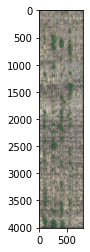

In [12]:
# How big (pixel size) was a single plot?
plot = np.load("/scratch/pawsey0149/modanilevicz/weed_data/inputImages_Masks/F1_field_160721/id_D_4_treat_11_image.npy")
plt.imshow(plot)

In [13]:
plot.shape

(4004, 807, 3)

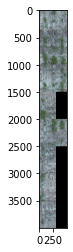

In [30]:
# Rebuild a sample image.
load_rgb = list(filter(lambda x: "f1_id_D_4_treat_11" in x, rgb_total))
full_image = np.zeros((4000, 500,3), dtype=np.uint8)
for i, path in enumerate(load_rgb):
    chunk = cv2.imread(path)
    full_image[500*i:500+500*i,:,:] = chunk
    
plt.imshow(full_image)

In [27]:
chunk.dtype

dtype('uint8')

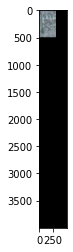

In [29]:
full_image = np.zeros((4000, 500,3),  dtype=np.uint8)
full_image[:500, :, :] = chunk
plt.imshow(full_image)

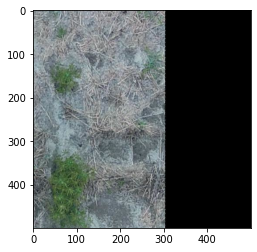

In [20]:
plt.imshow(cv2.imread(load_rgb[3]))

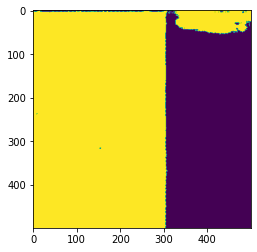

In [22]:
plt.imshow(img)